# Code for MHD Experiment

Import the usual stuff

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pn
import sys, os

os.chdir('/Users/7ag/active-manifolds/code_anthony/src')
# sys.path.insert(0,os.path.join(os.path.expanduser("~"),'active-manifolds/active_subspaces-master/active_subspaces/utils/'))
# sys.path.insert(0, 'src')

Import my functions

In [26]:
from functions.error_mains import *
from functions.main_base import *
from functions.plotfuncs import *

Define the necessary functions (written by Constantine)

In [29]:
coth = lambda x: 1./np.tanh(x)
sech = lambda x: 1./np.cosh(x)
csch = lambda x: 1./np.sinh(x)

l = 1.0
mu0 = 1.0

lb = np.log(np.array([.05, 1, .5, .5, .1])); ub = np.log(np.array([.2, 5, 3, 3, 1]))

#average velocity
def uavg(x):
	x = np.exp(x)
	return -x[:,2]*x[:,3]/x[:,4]**2*(1 - x[:,4]*l/np.sqrt(x[:,3]*x[:,0])*coth(x[:,4]*l/\
									np.sqrt(x[:,3]*x[:,0])))

#induced magnetic field
def Bind(x):
	x = np.exp(x)
	return x[:,2]*l*mu0/(2*x[:,4])*(1 - 2*np.sqrt(x[:,3]*x[:,0])/(x[:,4]*l)*np.tanh(x[:,4]*\
				l/(2*np.sqrt(x[:,3]*x[:,0]))))

#gradient of average velocity
def uavg_grad(x):
	x = np.exp(x)
	mu = x[:,0]; rho = x[:,1]; dp0 = x[:,2]; eta = x[:,3]; B0 = x[:,4]

	dudmu = -dp0*eta/B0**2*(B0*l/(2*np.sqrt(eta))*mu**(-3./2)*coth(B0*l/np.sqrt(eta*mu)) - \
			(B0*l)**2*np.sqrt(eta/mu)*csch(B0*l/np.sqrt(eta*mu))**2/(2*(eta*mu)**(3./2)))
	dudrho = 0.0*np.empty(x.shape[0])
	duddp0 = -eta/B0**2*(1 - B0*l/np.sqrt(eta*mu)*coth(B0*l/np.sqrt(eta*mu)))
	dudeta = -dp0/B0**2*(1 - B0*l/np.sqrt(eta*mu)*coth(B0*l/np.sqrt(eta*mu))) - \
		dp0*eta/B0**2*(B0*l/(2*np.sqrt(mu))*eta**(-3./2)*coth(B0*l/np.sqrt(eta*mu)) - \
			(B0*l)**2*np.sqrt(mu/eta)*csch(B0*l/np.sqrt(eta*mu))**2/(2*(eta*mu)**(3./2)))
	dudB0 = 2*dp0*eta/B0**3*(1 - B0*l/np.sqrt(eta*mu)*coth(B0*l/np.sqrt(eta*mu))) - \
		dp0*eta/B0**2*(-l/np.sqrt(eta*mu)*coth(B0*l/np.sqrt(eta*mu)) + B0*l**2/(eta*mu)*\
												csch(B0*l/np.sqrt(eta*mu))**2)

	dudmu = dudmu[:,None]; dudrho = dudrho[:,None]; duddp0 = duddp0[:,None]
	dudeta = dudeta[:,None]; dudB0 = dudB0[:,None]
	return np.hstack((dudmu, dudrho, duddp0, dudeta, dudB0))*x*(ub - lb).reshape((1, 5))/2.

#gradient of induced magnetic field
def Bind_grad(x):
	x = np.exp(x)
	mu = x[:,0]; rho = x[:,1]; dp0 = x[:,2]; eta = x[:,3]; B0 = x[:,4]

	dBdmu = dp0*l*mu0/(2*B0)*(-(B0*l)**-1*np.sqrt(eta/mu)*np.tanh(B0*l/(2*np.sqrt(eta*mu))) +\
				eta*np.sqrt(eta*mu)*sech(B0*l/(2*np.sqrt(eta*mu)))**2/(2*(eta*mu)**(3./2)))
	dBdrho = 0.0*np.empty(x.shape[0])
	dBddp0 = l*mu0/(2*B0)*(1 - 2*np.sqrt(eta*mu)/(B0*l)*np.tanh(B0*l/(2*np.sqrt(eta*mu))))
	dBdeta = dp0*l*mu0/(2*B0)*(-(B0*l)**-1*np.sqrt(mu/eta)*np.tanh(B0*l/(2*np.sqrt(eta*mu)))+\
				mu*np.sqrt(eta*mu)*sech(B0*l/(2*np.sqrt(eta*mu)))**2/(2*(eta*mu)**(3./2)))
	dBdB0 = -dp0*l*mu0/(2*B0**2)*(1 - 2*np.sqrt(eta*mu)/(B0*l)*np.tanh(B0*l/\
		(2*np.sqrt(eta*mu)))) + dp0*l*mu0/(2*B0)*(2*np.sqrt(eta*mu)/(B0**2*l)*np.tanh(\
		B0*l/(2*np.sqrt(eta*mu))) - B0**-1*sech(B0*l/(2*np.sqrt(eta*mu)))**2)

	dBdmu = dBdmu[:,None]; dBdrho = dBdrho[:,None]; dBddp0 = dBddp0[:,None]
	dBdeta = dBdeta[:,None]; dBdB0 = dBdB0[:,None]
	return np.hstack((dBdmu, dBdrho, dBddp0, dBdeta, dBdB0))*x*(ub - lb).reshape((1, 5))/2.


## Hartmann Problem

In [30]:
# Uniform mesh of inputs
meshy = make_mesh(0.2,5)
len(meshy)

# Bounds
lb = np.log(np.array([.05, 1, .5, .5, .1])); ub = np.log(np.array([.2, 5, 3, 3, 1]))

# Un-normalized log-inputs
xu = lb + 2./(ub-lb)*(np.array(meshy) + 1)

# Function values and gradients at exponentiated (non-log) inputs (np.exp in Constantine's stuff)
u = uavg(xu)
B = Bind(xu)
dB = Bind_grad(xu)
du = uavg_grad(xu)

# Normalization factors from chain rule
m = [(ub[i]-1)/(lb[i]+1) for i in xrange(5)]
m = np.array(m)
m = np.diagflat(m)

# Normalized, unit-length grads for AM
gradsu = preprocessing.normalize(np.matmul(du,m))
gradsB = preprocessing.normalize(np.matmul(dB,m))

### $u_{avg}$ Experiment

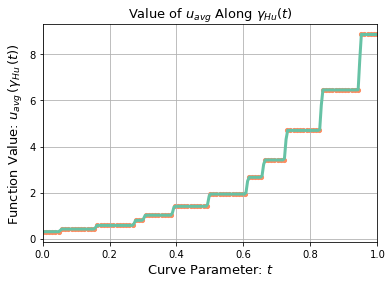

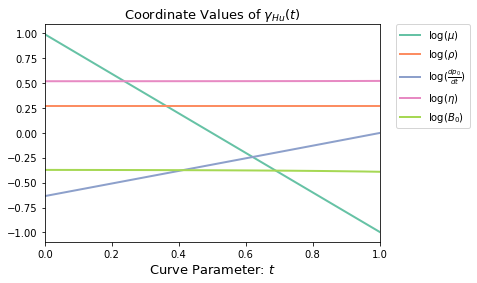

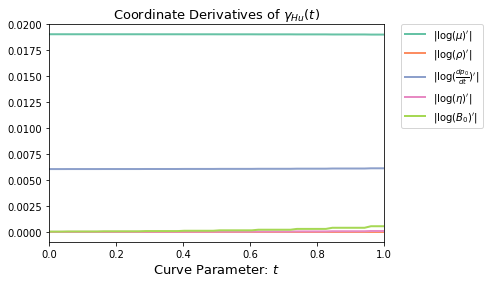

In [31]:
# Build AM corresponding to u_avg
np.random.seed(46)
am, fVals = build_AM_from_data(np.ravel(2*np.random.rand(5, 1) - 1),meshy,u,gradsu,0.02)

# Fit with cubic splines
splinefitHu(am,fVals)

# Parameters for plotting
numpts = len(am)
sValues = np.linspace(0., numpts, numpts) / (numpts)

# Coordinate Plot
fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_title(r'Coordinate Values of $\gamma_{Hu}(t)$', fontsize = 13)
ax.set_xlabel(r'Curve Parameter: $t$', fontsize = 13)
plt.plot(sValues, am[:,0], c='#66c2a5', label = r'$\log(\mu)$', markersize = 2, linewidth=2)
plt.plot(sValues, am[:,1], c='#fc8d62', label = r'$\log(\rho)$', markersize = 2,linewidth=2)
plt.plot(sValues, am[:,2], c='#8da0cb',  label = r'$\log(\frac{dp_0}{dt})$', markersize = 2,linewidth=2)
plt.plot(sValues, am[:,3], c='#e78ac3', label = r'$\log(\eta)$', markersize = 2,linewidth=2)
plt.plot(sValues, am[:,4], c='#a6d854', label = r'$\log(B_0)$', markersize = 2,linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0,1)
plt.savefig('Hartmann_uCoords.pdf',bbox_inches = 'tight')

# Derivative Plot
fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_title(r'Coordinate Derivatives of $\gamma_{Hu}(t)$', fontsize = 13)
ax.set_xlabel(r'Curve Parameter: $t$', fontsize = 13)
plt.plot(sValues,np.abs(np.gradient(am[:,0])), c='#66c2a5', label = r'$|\log(\mu)^\prime|$', markersize = 3, linewidth=2)
plt.plot(sValues,np.abs(np.gradient(am[:,1])), c='#fc8d62', label = r'$|\log(\rho)^\prime|$', markersize = 3, linewidth=2)
plt.plot(sValues,np.abs(np.gradient(am[:,2])), c='#8da0cb',  label = r'$|\log(\frac{dp_0}{dt})^\prime|$', markersize = 3, linewidth=2)
plt.plot(sValues,np.abs(np.gradient(am[:,3])), c='#e78ac3', label = r'$|\log(\eta)^\prime|$', markersize = 3, linewidth=2)
plt.plot(sValues,np.abs(np.gradient(am[:,4])), c='#a6d854', label = r'$|\log(B_0)^\prime|$', markersize = 3, linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0,1)
plt.savefig('Hartmann_uDerivs.pdf',bbox_inches='tight')

#### Error comparison AM vs AS

level set for data point  [-0.55555556  1.         -1.         -1.          0.55555556],  2000 of 2000
The L1 Error is 1.357151
The L2 Error is 0.048149
The R^2 value of the response surface is 0.8898


(4.8671844393127408, 7.1212926625177513)

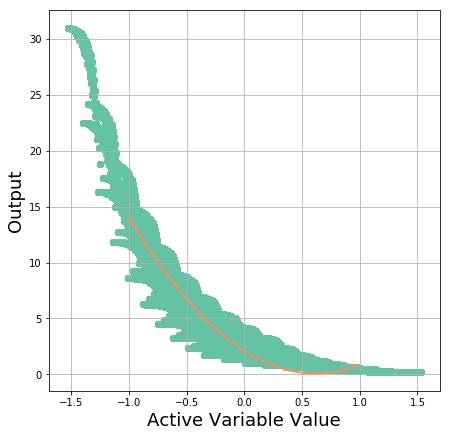

In [12]:
mainRandEx(46, 5, np.array(meshy), u, gradsu, 0.15, 98000, 'hartu-AM')
SubspEx(46, np.array(meshy), u, du, 98000, 'hartu-AS')

### $B_{ind}$ Experiment

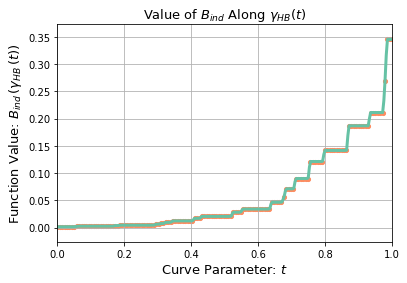

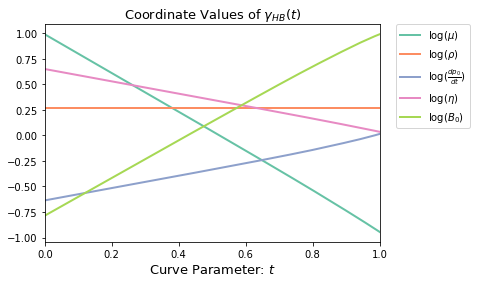

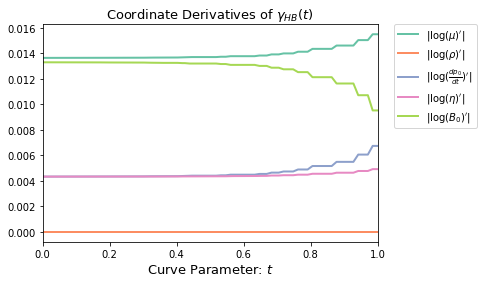

In [32]:
# Build AM corresponding to B_ind
np.random.seed(46)
am2, fVals2 = build_AM_from_data(np.ravel(2*np.random.rand(5, 1) - 1),meshy,B,gradsB,0.02)

# Fit with splines
splinefitHB(am2,fVals2)

# Parameter for plots
numpts2 = len(am2)
sValues2 = np.linspace(0., numpts2, numpts2) / (numpts2)

# Coordinate Plot
fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_title(r'Coordinate Values of $\gamma_{HB}(t)$', fontsize = 13)
ax.set_xlabel(r'Curve Parameter: $t$', fontsize = 13)
plt.plot(sValues2, am2[:,0], c='#66c2a5', label = r'$\log(\mu)$', markersize = 3, linewidth=2)
plt.plot(sValues2, am2[:,1], c='#fc8d62', label = r'$\log(\rho)$', markersize = 3, linewidth=2)
plt.plot(sValues2, am2[:,2], c='#8da0cb',  label = r'$\log(\frac{dp_0}{dt})$', markersize = 3, linewidth=2)
plt.plot(sValues2, am2[:,3], c='#e78ac3', label = r'$\log(\eta)$', markersize = 3, linewidth=2)
plt.plot(sValues2, am2[:,4], c='#a6d854', label = r'$\log(B_0)$', markersize = 3, linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0,1)
plt.savefig('Hartmann_BCoords.pdf',bbox_inches='tight')

# Derivative Plot
fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_title(r'Coordinate Derivatives of $\gamma_{HB}(t)$', fontsize = 13)
ax.set_xlabel(r'Curve Parameter: $t$', fontsize = 13)
plt.plot(sValues2,np.abs(np.gradient(am2[:,0])), c='#66c2a5', label = r'$|\log(\mu)^\prime|$', markersize = 3, linewidth=2)
plt.plot(sValues2,np.abs(np.gradient(am2[:,1])), c='#fc8d62', label = r'$|\log(\rho)^\prime|$', markersize = 3, linewidth=2)
plt.plot(sValues2,np.abs(np.gradient(am2[:,2])), c='#8da0cb',  label = r'$|\log(\frac{dp_0}{dt})^\prime|$', markersize = 3, linewidth=2)
plt.plot(sValues2,np.abs(np.gradient(am2[:,3])), c='#e78ac3', label = r'$|\log(\eta)^\prime|$', markersize = 3, linewidth=2)
plt.plot(sValues2,np.abs(np.gradient(am2[:,4])), c='#a6d854', label = r'$|\log(B_0)^\prime|$', markersize = 3, linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0,1)
plt.savefig('Hartmann_BDerivs.pdf',bbox_inches='tight')

#### Error Comparison AM vs AS

level set for data point  [-0.55555556  1.         -1.         -1.          0.55555556],  2000 of 2000
The L1 Error is 0.069979
The L2 Error is 0.003495
The R^2 value of the response surface is 0.8091


(0.14676655589242599, 0.23180265754072069)

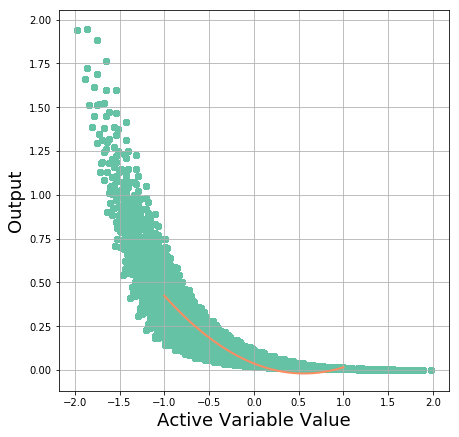

In [14]:
mainRandEx(46, 5, np.array(meshy), B, gradsB, 0.15, 98000, 'hartB-AM')
SubspEx(46, np.array(meshy), B, dB, 98000, 'hartB-AS')

## Idealized MHD Generator Problem

In [33]:
# Load data from data files
data = pn.DataFrame.from_csv('/Users/7ag/active-manifolds/code_anthony/as-data-sets/MHD/MHD_Generator_Data_Uavg.txt').as_matrix()
Xu = data[:,:5]; u = data[:,5]; du = data[:,6:]
data = pn.DataFrame.from_csv('/Users/7ag/active-manifolds/code_anthony/as-data-sets/MHD/MHD_Generator_Data_Bind.txt').as_matrix()
XB = data[:,:5]; B = data[:,5]; dB = data[:,6:]

# New upper/lower bounds
lb = np.log(np.array([.001, .1, .1, .1, .1])); ub = np.log(np.array([.01, 10, .5, 10, 1]))

# Scale gradients according to the chain rule, get normalized inputs
du = .5*(ub - lb)*Xu*du; XXu = 2*(np.log(Xu) - lb)/(ub - lb) - 1
dB = .5*(ub - lb)*XB*dB; XXB = 2*(np.log(XB) - lb)/(ub - lb) - 1

# Get unit lenth grads for AM
normdu = preprocessing.normalize(du)
normdB = preprocessing.normalize(dB)

### $u_{ind}$ Experiment

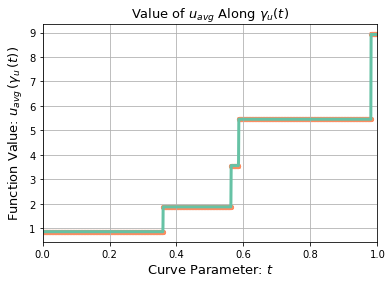

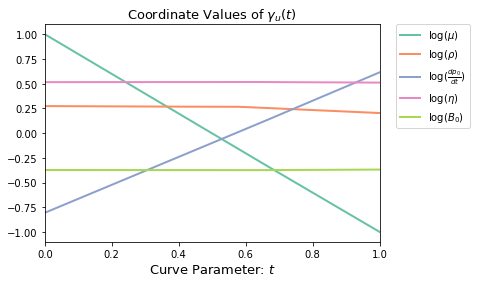

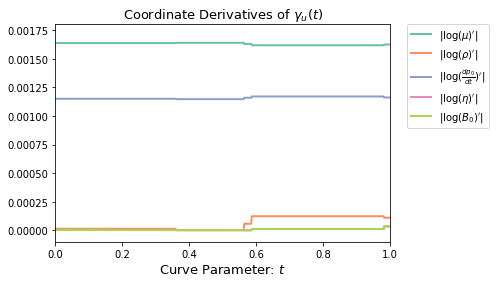

In [34]:
# Build AM corresponding to u_ind
np.random.seed(46)
am, fVals = build_AM_from_data(np.ravel(2*np.random.rand(5, 1) - 1),XXu,u,normdu,0.002)

# Fit with splines
splinefitu(am,fVals)

# Parameter for plots
numpts = len(am)
sValues = np.linspace(0., numpts, numpts) / (numpts)

# Coordinate Plot
fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_title(r'Coordinate Values of $\gamma_u(t)$', fontsize = 13)
ax.set_xlabel(r'Curve Parameter: $t$', fontsize = 13)
plt.plot(sValues, am[:,0], c='#66c2a5', label = r'$\log(\mu)$', markersize = 2, linewidth=2)
plt.plot(sValues, am[:,1], c='#fc8d62', label = r'$\log(\rho)$', markersize = 2,linewidth=2)
plt.plot(sValues, am[:,2], c='#8da0cb',  label = r'$\log(\frac{dp_0}{dt})$', markersize = 2,linewidth=2)
plt.plot(sValues, am[:,3], c='#e78ac3', label = r'$\log(\eta)$', markersize = 2,linewidth=2)
plt.plot(sValues, am[:,4], c='#a6d854', label = r'$\log(B_0)$', markersize = 2,linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0,1)
plt.savefig('MHD_uCoords.pdf', bbox_inches='tight')

# Derivative Plot
fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_title(r'Coordinate Derivatives of $\gamma_u(t)$', fontsize = 13)
ax.set_xlabel(r'Curve Parameter: $t$', fontsize = 13)
plt.plot(sValues,np.abs(np.gradient(am[:,0])), c='#66c2a5', label = r'$|\log(\mu)^\prime|$', markersize = 3, linewidth=2)
plt.plot(sValues,np.abs(np.gradient(am[:,1])), c='#fc8d62', label = r'$|\log(\rho)^\prime|$', markersize = 3, linewidth=2)
plt.plot(sValues,np.abs(np.gradient(am[:,2])), c='#8da0cb',  label = r'$|\log(\frac{dp_0}{dt})^\prime|$', markersize = 3, linewidth=2)
plt.plot(sValues,np.abs(np.gradient(am[:,3])), c='#e78ac3', label = r'$|\log(\eta)^\prime|$', markersize = 3, linewidth=2)
plt.plot(sValues,np.abs(np.gradient(am[:,4])), c='#a6d854', label = r'$|\log(B_0)^\prime|$', markersize = 3, linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0,1)
plt.ylim(-0.0001,0.0018)
plt.savefig('MHD_uDerivs.pdf', bbox_inches='tight')

#### Error Comparison AM vs AS

level set for data point  [-0.73364317  0.48433173  0.81643439  0.05755649  0.69914205],  100 of 100
The L1 Error is 0.819112
The L2 Error is 0.142808
The R^2 value of the response surface is 0.9639


(2.2096103776984193, 2.8768740360896703)

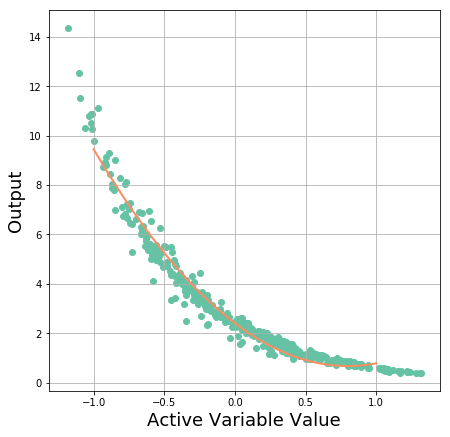

In [9]:
mainRandEx(46, 5, XXu, u, normdu, 0.01, 383, 'MHDu-AM')
SubspEx(46, XXu, u, du, 383, 'MHDu-AS')

### $B_{ind}$ Experiment

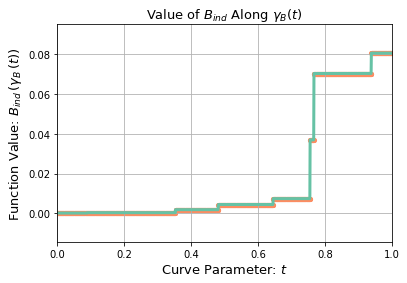

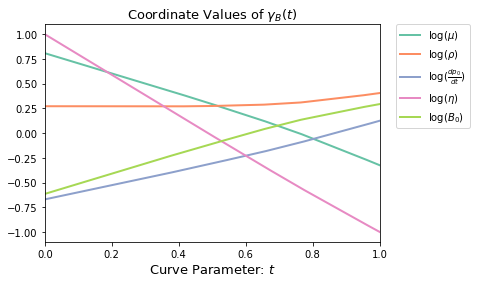

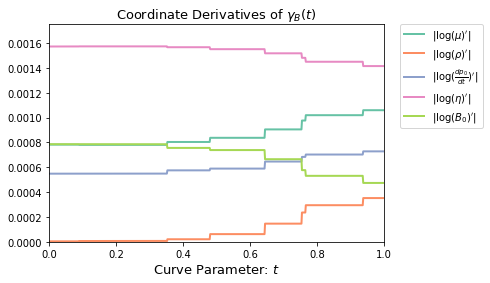

In [35]:
# Build AM corresponding to B_ind
np.random.seed(46)
am2, fVals2 = build_AM_from_data(np.ravel(2*np.random.rand(5, 1) - 1),XXB,B,normdB,0.002)

# Fit with splines
splinefitB(am2,fVals2)

# Parameter for plots
numpts2 = len(am2)
sValues2 = np.linspace(0., numpts2, numpts2) / (numpts2)

# Coordinate Plot
fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_title(r'Coordinate Values of $\gamma_B(t)$', fontsize = 13)
ax.set_xlabel(r'Curve Parameter: $t$', fontsize = 13)
plt.plot(sValues2, am2[:,0], c='#66c2a5', label = r'$\log(\mu)$', markersize = 3, linewidth=2)
plt.plot(sValues2, am2[:,1], c='#fc8d62', label = r'$\log(\rho)$', markersize = 3, linewidth=2)
plt.plot(sValues2, am2[:,2], c='#8da0cb',  label = r'$\log(\frac{dp_0}{dt})$', markersize = 3, linewidth=2)
plt.plot(sValues2, am2[:,3], c='#e78ac3', label = r'$\log(\eta)$', markersize = 3, linewidth=2)
plt.plot(sValues2, am2[:,4], c='#a6d854', label = r'$\log(B_0)$', markersize = 3, linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0,1)
plt.savefig('MHD_BCoords.pdf', bbox_inches='tight')

# Derivative Plot
fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_title(r'Coordinate Derivatives of $\gamma_B(t)$', fontsize = 13)
ax.set_xlabel(r'Curve Parameter: $t$', fontsize = 13)
plt.plot(sValues2,np.abs(np.gradient(am2[:,0])), c='#66c2a5', label = r'$|\log(\mu)^\prime|$', markersize = 3, linewidth=2)
plt.plot(sValues2,np.abs(np.gradient(am2[:,1])), c='#fc8d62', label = r'$|\log(\rho)^\prime|$', markersize = 3, linewidth=2)
plt.plot(sValues2,np.abs(np.gradient(am2[:,2])), c='#8da0cb',  label = r'$|\log(\frac{dp_0}{dt})^\prime|$', markersize = 3, linewidth=2)
plt.plot(sValues2,np.abs(np.gradient(am2[:,3])), c='#e78ac3', label = r'$|\log(\eta)^\prime|$', markersize = 3, linewidth=2)
plt.plot(sValues2,np.abs(np.gradient(am2[:,4])), c='#a6d854', label = r'$|\log(B_0)^\prime|$', markersize = 3, linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0,1)
plt.ylim(0,0.00175)
plt.savefig('MHD_BDerivs.pdf', bbox_inches='tight')

#### Error Comparison AM vs AS

level set for data point  [ 0.28143827  0.74880224  0.93587292 -0.30847992 -0.28910861],  100 of 100
The L1 Error is 0.003960
The L2 Error is 0.000757
The R^2 value of the response surface is 0.8371


(0.015065121723495367, 0.022475799756748197)

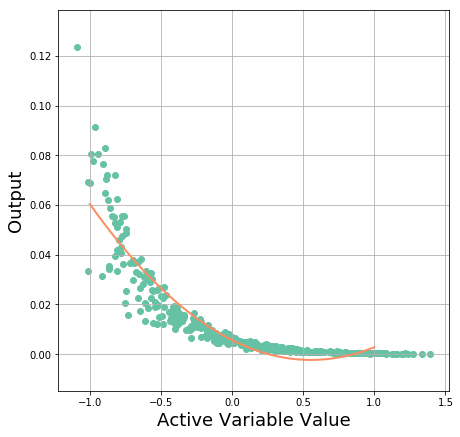

In [8]:
mainRandEx(46, 5, XXB, B, normdB, 0.01, 383, 'MHDB-AM')
SubspEx(46, XXB, B, dB, 383, 'MHDB-AS')